# This document is to show that when we have diffusivity equals to zero at our domain, the concetation at the point will not change at all.

In [8]:
import numpy as np
import datetime
import threading
import multiprocessing as mp
from matplotlib import pyplot as plt
from time import time
from scipy.stats import norm
import sympy
%matplotlib inline
plt.style.use('bmh')
import scipy
from scipy import stats
from scipy import sparse
from scipy.sparse import linalg
from scipy.sparse.linalg import spsolve
from scipy.stats import norm

In [9]:
z = sympy.symbols('z')
K0 = 1e-6
K1 = 6e-3# m / s
Aalpha = 0.5
c=20
w=0

sym_Diffu =  K0 + K1 * z * sympy.exp(-Aalpha * z)#*(sympy.tanh(c*(z+0.05)))
sym_dKdz = sympy.diff(sym_Diffu, z, 1)
sym_Beta = sympy.sqrt(2 * sym_Diffu)
sym_dBdz = sympy.diff(sym_Beta, z, 1)
sym_ddBdzz = sympy.diff(sym_Beta, z, 2)
sym_Alpha = w + sym_dKdz
sym_dAdz = sympy.diff(sym_Alpha, z, 1)
sym_ddAdzz = sympy.diff(sym_Alpha, z, 2)
sym_dABdz = sympy.diff(sym_Alpha * sym_Beta, z, 1)

Diffu  =  sympy.utilities.lambdify(z,          sym_Diffu,np)
dKdz   =  sympy.utilities.lambdify(z,          sym_dKdz,np)
Beta   =  sympy.utilities.lambdify(z,          sym_Beta,np)
dBdz   =  sympy.utilities.lambdify(z,          sym_dBdz,np)
ddBdzz=  sympy.utilities.lambdify(z,          sym_ddBdzz,np)
Alpha =  sympy.utilities.lambdify(z,      sym_Alpha,np)
dAdz  =  sympy.utilities.lambdify(z,      sym_dAdz,np)
ddAdzz=  sympy.utilities.lambdify(z,      sym_ddAdzz,np)
dABdz =  sympy.utilities.lambdify(z, sym_Alpha*sym_Beta,np)

### Functions

In [10]:
def Gaussian(z, mu, sigma):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-((z-mu)/sigma)**2/2)


def OneTimeStep(C, K, dKdz, dt, z):
    
    dz = z[1]-z[0]
     #We need two extra ghost points at the start and the end.   
    NyC=np.empty(C.shape[0]+2, dtype=float)
    NyC[1:-1]=C.copy()
    
    NyC[0] = NyC[2]
    NyC[-1] = NyC[-3]
    
    dC=dKdz*(NyC[2:]-NyC[0:-2])/(2*dz)+K*(NyC[2:]-2*NyC[1:-1]+NyC[0:-2])/(dz**2)
            
    dC=dt*dC;
    C=C+dC
    return C

def OneTimeStep2(C, K, dt, z):
    dz = z[1] - z[0]
     #We need two extra ghost points at the start and the end.   
    NyC=np.empty(C.shape[0]+2, dtype=float)
    NyC[1:-1]=C.copy()
    NyC[0] = NyC[2]
    NyC[-1] = NyC[-3]
    
    #We need two extra ghost points at the start and the end.   
    dKdz=np.empty(K.shape[0], dtype=float)
    dKdz[1:-1] = (K[2:]- K[:-2])/(2*dz)
    dKdz[0] = 0
    dKdz[-1] = 0
    
    dC=dKdz*(NyC[2:]-NyC[0:-2])/(2*dz)+K*(NyC[2:]-2*NyC[1:-1]+NyC[0:-2])/(dz**2)
            
    dC=dt*dC;
    C=C+dC
    return C

def crankNicolson(C0, D0, X, dt, Tmax):
    # Numerical parameters
    dx = X[1] - X[0]
    Nx = X.size
    Nt = int(Tmax / dt)
    a  = dt/(8*dx**2)
    b  = dt/(4*dx)
    
    # Problem arrays
    # Pad with halo cells and 
    # copy elements onto boundary
    #C      = np.zeros((Nt+1, Nx))
    C = C0.copy()
    # Diffusivity (here constant in time)
    #D      = np.zeros(Nx)
    D   = D0.copy()
    # Create system matrices
    # Equation is L C_i = R C_{i+1}
    # Left hand side
    L = np.zeros((Nx, Nx))
    # Fill non-boundary points first
    L[1:-1,1:-1] += np.diag(1 - 8*a*D[1:-1], 0)
    L[:-1,:-1] += np.diag(-a*(D[2:]-D[:-2]) + 4*a*D[ 1:-1], -1)
    L[1:,1:] += np.diag( a*(D[2:]-D[:-2]) + 4*a*D[1:-1], +1)
    # No-diffusive-flux BC at top
    L[ 0, 0] = 1 - 8*a*D[0]
    L[ 0, 1] = 8*a*D[0]
    # No-diffusive-flux  BC at bottom
    L[-1,-1] = 1 - 8*a*D[-1]
    L[-1,-2] = 8*a*D[-1]
    # Convert to sparse matrix
    L  = scipy.sparse.csr_matrix(L)
    # Right hand side
    R = np.zeros((Nx, Nx))
    # Fill non-boundary points first
    R[1:-1,1:-1] += np.diag(1 + 8*a*D[1:-1], 0)
    R[:-1,:-1] += np.diag( a*(D[2:]-D[:-2]) - 4*a*D[ 1:-1], -1)
    R[1:,1:] += np.diag(-a*(D[2:]-D[:-2]) - 4*a*D[1:-1], +1)
    # No-diffusive-flux  BC at top
    R[ 0, 0] = 1 + 8*a*D[0]
    R[ 0, 1] = -8*a*D[0]
    # No-diffusive-flux  BC at bottom
    R[-1,-1] = 1 + 8*a*D[-1]
    R[-1,-2] = -8*a*D[-1]
    # Convert to sparse matrix
    R  = scipy.sparse.csr_matrix(R)
    # We do not need the history of the concetration
    #C=C[0,:]
    for t in range(Nt):
        x = L.dot(C)
        C = spsolve(R, x)
    return C


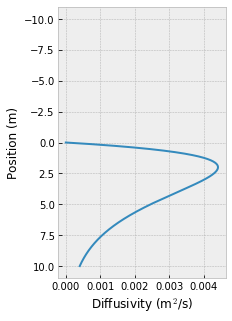

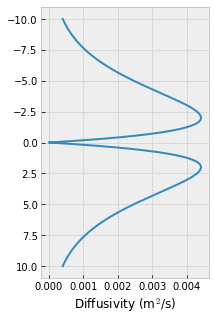

In [50]:
x = np.linspace(0, 10, 2000)
K = Diffu(x)

plt.figure(figsize=(3,5))
plt.plot(K, x)
plt.ylabel("Position (m)")
plt.xlabel("Diffusivity (m$^2$/s)")
plt.ylim(-11,11)
plt.gca().invert_yaxis()
plt.tight_layout
plt.show()

x_mirror = -1*np.flip(x, 0)
K_mirror = np.flip(K, 0)

x_mirror = np.delete(x_mirror, -1)
K_mirror = np.delete(K_mirror, -1)

x_mirror = np.append(x_mirror, x)
K_mirror = np.append(K_mirror, K)

plt.figure(figsize=(3,5))
plt.plot(K_mirror, x_mirror)
#plt.ylabel("Position (m)")
plt.xlabel("Diffusivity (m$^2$/s)")
plt.ylim(-11,11)
plt.gca().invert_yaxis()
plt.tight_layout
plt.show()

In [58]:
#y0 = np.random.uniform(8, 10, x.size)
#y0 = np.cos(1/2*np.pi*x)+9

y0 = (norm.pdf(x, 5, 0.01))
y0_mirror = np.flip(y0, 0)
y0_mirror = np.delete(y0_mirror, -1)
y0_mirror = np.append(y0_mirror, y0)

time =1000

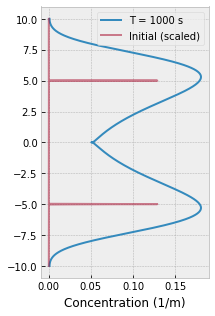

In [67]:
y_mirror = crankNicolson(y0_mirror, K_mirror, x_mirror, 0.5, time)
plt.figure(figsize=(3,5))
plt.plot(y_mirror, x_mirror, label = "T = 1000 s")
plt.plot(y0_mirror/300,x_mirror, alpha = 0.5, label = "Initial (scaled)")
plt.xlabel("Concentration (1/m)")
plt.gca().invert_yaxis()
plt.legend()
plt.ylim(-11,11)
plt.tight_layout
plt.show()

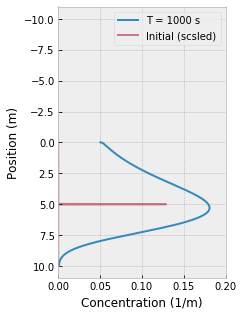

In [70]:
y = crankNicolson(y0, K, x, 0.5, time)
plt.figure(figsize=(3,5))
plt.plot(y, x, label = "T = 1000 s")
plt.plot(y0/300,x, alpha = 0.5, label = "Initial (scsled)")
plt.ylabel("Position (m)")
plt.xlabel("Concentration (1/m)")
plt.ylim(-11,11)
plt.xlim(0, 0.2)
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout
plt.show()